In [1]:
# Manipulation des données
import pandas as pd

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitement des données
from sklearn.preprocessing import  MinMaxScaler, OneHotEncoder

# Réduction de dimension

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# afficher toutes les colonnes du dataframe
pd.set_option('display.max_columns', None)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
import warnings 
warnings.simplefilter(action='ignore', category=Warning)

## Evolution dans le temps

In [2]:
# chargement du fichier
simul = pd.read_csv('simulation.csv')

In [3]:
# division des données en periode
# Période d'entrainement du modèle initial: jusqu'à janvier 2018
df_2017 = simul[simul['order_purchase_timestamp'] < '2018-02-01']

# Période de test initial: février 2018 à avril 2018
df_test = simul[simul['order_purchase_timestamp'] >= '2018-02-01']
df_test = df_test[df_test['order_purchase_timestamp'] <= '2018-07-17']

# control de perf avec une df des 2 années
df_total = pd.concat([df_2017, df_test])

### préparation des données pour la simulation

In [4]:

print(df_2017.describe(), df_test.describe(), df_total.describe())

       Montant_total  Poids Produit     Fréquence         Score       Récence
count   50059.000000    50059.00000  50059.000000  50059.000000  50059.000000
mean      140.127066     2177.78801      1.030544      4.074668    405.486885
std       219.726295     3915.39413      0.187630      1.335662    103.623527
min         0.000000        0.00000      1.000000      1.000000    258.000000
25%        45.900000      300.00000      1.000000      4.000000    320.000000
50%        87.160000      700.00000      1.000000      5.000000    387.000000
75%       152.895000     1850.00000      1.000000      5.000000    487.000000
max     13440.000000    40425.00000      6.000000      5.000000    650.000000        Montant_total  Poids Produit     Fréquence         Score       Récence
count   35638.000000   35638.000000  35638.000000  35638.000000  35638.000000
mean      143.603683    2030.196756      1.038330      4.049081    179.245300
std       211.824569    3636.369192      0.227327      1.368817 

### Traitement des outliers

In [5]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [6]:

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [7]:
# Séparer les colonnes numériques et non numériques
num_cols = df_2017.select_dtypes(include=['number']).columns
non_num_cols = df_2017.select_dtypes(exclude=['number']).columns

In [8]:
outlier_thresholds(df_2017, num_cols)

(Montant_total    -114.5925
 Poids Produit   -2025.0000
 Fréquence           1.0000
 Score               2.5000
 Récence            69.5000
 dtype: float64,
 Montant_total     313.3875
 Poids Produit    4175.0000
 Fréquence           1.0000
 Score               6.5000
 Récence           737.5000
 dtype: float64)

In [9]:
outlier_thresholds(df_total, num_cols)

(Montant_total    -116.85
 Poids Produit   -1969.50
 Fréquence           1.00
 Score               2.50
 Récence          -129.50
 dtype: float64,
 Montant_total     317.95
 Poids Produit    4082.50
 Fréquence           1.00
 Score               6.50
 Récence           738.50
 dtype: float64)

In [10]:
outlier_thresholds(df_test, num_cols)

(Montant_total    -114.83
 Poids Produit   -1975.00
 Fréquence           1.00
 Score               2.50
 Récence            21.50
 dtype: float64,
 Montant_total     318.45
 Poids Produit    3985.00
 Fréquence           1.00
 Score               6.50
 Récence           337.50
 dtype: float64)

In [11]:
cols_to_remplace = ['Poids Produit']

for col in cols_to_remplace:
    replace_with_thresholds(df_2017, col)
    
for col in cols_to_remplace:
    replace_with_thresholds(df_total, col)
    
for col in cols_to_remplace:
    replace_with_thresholds(df_test, col)

In [12]:
print(df_2017.shape, df_test.shape, df_total.shape)

(50059, 7) (35638, 7) (85697, 7)


### Scaler

In [13]:
# Appliquer MinMaxScaler seulement sur les colonnes numériques
mms = MinMaxScaler()
df_2017_scaled = mms.fit_transform(df_2017[num_cols])
# Recréer le DataFrame avec les colonnes non numériques
df_2017_scaled = pd.DataFrame(df_2017_scaled, columns=num_cols, index=df_2017.index)
# Ajouter les colonnes non numériques
df_2017_scaled[non_num_cols] = df_2017[non_num_cols]

# Utilisation du MinMaxScaler df_test
df_test_scaled = mms.transform(df_test[num_cols])
# Recréer le DataFrame avec les colonnes non numériques
df_test_scaled = pd.DataFrame(df_test_scaled, columns=num_cols, index=df_test.index)
# Ajouter les colonnes non numériques
df_test_scaled[non_num_cols] = df_test[non_num_cols]


# Appliquer MinMaxScaler seulement sur les colonnes numériques
mms = MinMaxScaler()
df_total_scaled = mms.fit_transform(df_total[num_cols])
# Recréer le DataFrame avec les colonnes non numériques
df_total_scaled = pd.DataFrame(df_total_scaled, columns=num_cols, index=df_total.index)
# Ajouter les colonnes non numériques
df_total_scaled[non_num_cols] = df_total[non_num_cols]

## Simulation d'ajout de clienteles

In [14]:
# sauvegarde des données
df_2017_scaled.to_csv('df_2017.csv', index=False)
df_test_scaled.to_csv('df_2018.csv', index=False)
df_total_scaled.to_csv('df_total.csv', index=False)

In [15]:
# chargement des données
df_2017 = pd.read_csv('df_2017.csv')
df_test = pd.read_csv('df_2018.csv')
df_total = pd.read_csv('df_total.csv')

In [16]:
# selection de varaibles numérique 
num_cols = df_2017.select_dtypes(include=['number']).columns

# Entraînement du modèle sur total
km_total = KMeans(n_clusters=5, random_state=42).fit(df_total[num_cols])
df_total['segments'] = km_total.labels_

# Entraînement du modèle sur 2017
km17 = KMeans(n_clusters=5, random_state=42).fit(df_2017[num_cols])
df_2017['cluster'] = km17.labels_
# prédiction sur df test
Prediction = km17.predict(df_test[num_cols])

# ajout des colonne prédiction et nv segment dans df test
df_test['predictions'] = Prediction
# via la clef customer_unique id on ajoute le segment
df_test = pd.merge(df_test, df_total[['customer_unique_id', 'segments']], on='customer_unique_id', how='left')


In [17]:
# Calcul des scores
#print('Silhouette score 2017: ', silhouette_score(df_2017[num_cols], df_2017['cluster']))
#print('Silhouette score total: ', silhouette_score(df_total, km_total.labels_))
print('ARI: ', adjusted_rand_score(df_test['segments'], df_test['predictions']))

ARI:  0.8000496425083807


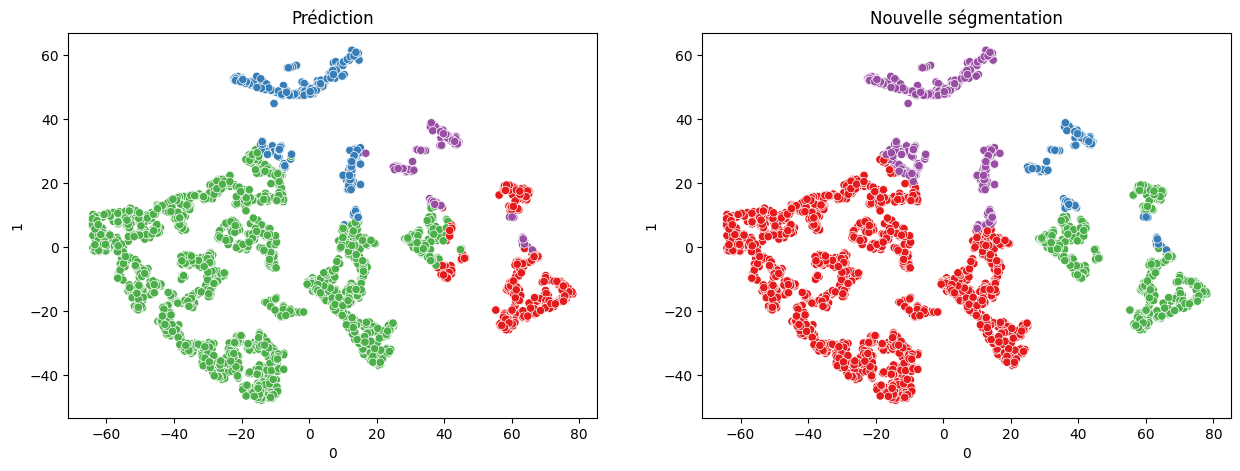

In [18]:
# echantillonage
df_test_sample = df_test.sample(3000)

tsne = TSNE(random_state=0)
tsne.fit_transform(df_test_sample[num_cols])

df_tsne = pd.DataFrame(tsne.embedding_, index=df_test_sample.index)
df_tsne['cluster'] = df_test_sample['predictions']
df_tsne['cluster_total'] = df_test_sample['segments']

# 2 figures sur la même image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x=0, y=1, hue='cluster', data=df_tsne, ax=ax1, legend=False, palette='Set1')
sns.scatterplot(x=0, y=1, hue='cluster_total', data=df_tsne, ax=ax2, legend=False, palette='Set1')
ax1.set_title('Prédiction')
ax2.set_title('Nouvelle ségmentation')
plt.show()

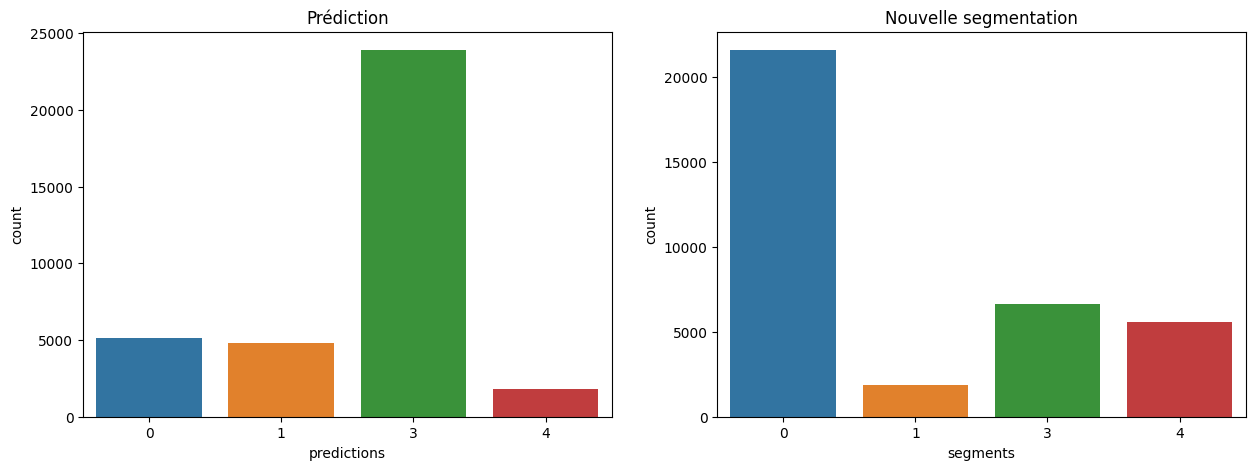

In [19]:
# Création des histogrammes pour 'predictions' et 'segments'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogramme pour 'predictions'
sns.countplot(x='predictions', data=df_test, ax=ax1)
ax1.set_title('Prédiction')

# Histogramme pour 'segments'
sns.countplot(x='segments', data=df_test, ax=ax2)
ax2.set_title('Nouvelle segmentation')

plt.show()
